# Image Segmentation

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torchmetrics

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## Data

In [3]:
data_dir = '../../dataset/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
unlabel_dir = data_dir + 'unlabeled/'

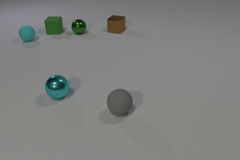

In [4]:
img = Image.open(data_dir + "train/video_0/image_21.png")
img

(22, 160, 240)


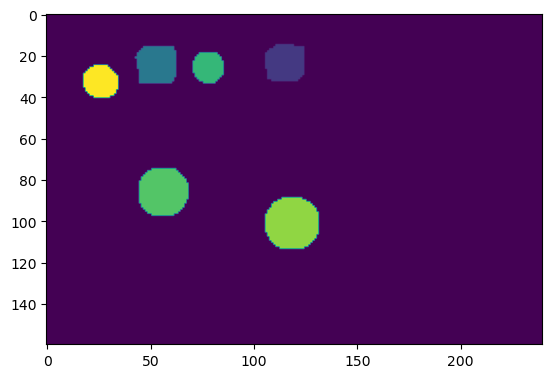

In [5]:
masks = np.load(data_dir + "train/video_0/mask.npy")
print(masks.shape)
plt.imshow(masks[21])

In [6]:
mask = np.load(data_dir + "train/video_0/mask.npy")[0]
obj_ids = np.unique(mask)  # instances are encoded as different colors
obj_ids = obj_ids[1: ]     # remove background (1st id)
print(obj_ids)

num_objs = len(obj_ids)

[ 5 12 20 22 25 30]


### Dataset

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, root, transform, num_classes=49):
        self.root = root
        self.transform = transform
        self.vid_list = sorted(os.listdir(root))
        self.num_videos = len(self.vid_list)
        self.imgs = ['image_' + str(i) + '.png' for i in range(22)]
    
    def __len__(self):
        return self.num_videos * 22

    def __getitem__(self, idx):
        vid_idx = idx // 22
        img_idx = idx % 22

        # load images and masks
        img_path = os.path.join(self.root, self.vid_list[vid_idx], self.imgs[img_idx])
        masks_path = os.path.join(self.root, self.vid_list[vid_idx], 'mask.npy')
        img = Image.open(img_path).convert("RGB")
        mask = np.load(masks_path)[img_idx]
        
        obj_ids = np.unique(mask)  # instances are encoded as different colors
        obj_ids = obj_ids[1: ]     # remove background (1st id)
        num_objs = len(obj_ids)

        
        masks = (mask == obj_ids[:, None, None])  # split the color-encoded mask into a set of binary masks

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        target = {}
        # target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id

        img = self.transform(img)

        return img, target

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = VideoDataset(train_dir, transform)
loader_train = DataLoader(dataset_train, batch_size=8, shuffle=False)

img, target = dataset_train[0]
target